# Analysis of the beers prices dataset from Beerizer

In [207]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display

In [208]:
df_beerizer = pd.read_csv('official_beerizer_dataset.csv')
print(df_beerizer.head())
print(f"Initial shape of the dataset: {df_beerizer.shape}")

                    Beer_name    Price       Origin Rating  \
0                        Glas   € 5,50      England   3.83   
1            Meesterstuk 2025  € 13,99  Netherlands   4.11   
2            Meesterstuk 2025   € 6,99  Netherlands   4.11   
3  Do Not Eat the Yellow Snow   € 5,59  Netherlands   3.66   
4           Liqour 43 Infused   € 3,79  Netherlands      ?   

                  Brewery Percentage                      Beer_type  \
0   Azvex Brewing Company       5.2%  Pale Ale - New England / Hazy   
1                   Jopen     11.11%                 Stout - Pastry   
2                   Jopen     11.11%                 Stout - Pastry   
3  Uiltje Brewing Company       8.9%        IPA - Imperial / Double   
4   Guilty Monkey Brewery       7.6%              Belgian Quadrupel   

    Countenance Countenance_per_litre  
0           NaN                   NaN  
1  Bottle 750ml     € 18,65 per litre  
2  Bottle 750ml     € 18,65 per litre  
3  Bottle 750ml     € 18,65 per litre  


We used data scraped from Beerizer, a website selling many beers, which therefore displays comparable prices.

## Dataset preprocessing

After a first look, the retrieved data is not perfect and need some preprocessing.
- Basic preprocessing
- convert numbers values to float
- create volume column
- recalculate price per litter

In [209]:
#drop rows with missing values
df_beerizer = df_beerizer.dropna()
print(f"Number of entries after removing lines with missing values: {len(df_beerizer)}")
#remove duplicates
df_beerizer = df_beerizer.drop_duplicates(keep='first')
print(f"Number of entries after removing duplicates: {len(df_beerizer)}")

Number of entries after removing lines with missing values: 28973
Number of entries after removing duplicates: 28547


In [210]:
#correct price column
#remove € sign and convert to float
df_beerizer['Price'] = df_beerizer['Price'].str.replace('€', '', regex=False)
df_beerizer['Price'] = df_beerizer['Price'].str.replace('.', '', regex=False)
df_beerizer['Price'] = df_beerizer['Price'].str.replace(',', '.', regex=False)
df_beerizer['Price'] = df_beerizer['Price'].astype(float)
df_beerizer = df_beerizer.rename(columns={'Price': 'Price_euro'}) #rename column to have a more explicit name

print(f"Mean price of a beer: {df_beerizer['Price_euro'].mean():.2f}€\nMedian price of a beer: {df_beerizer['Price_euro'].median():.2f}€")

df_beerizer = df_beerizer.sort_index() 

Mean price of a beer: 14.01€
Median price of a beer: 7.10€


The mean price seems high. After exploring the data, it comes from some very expensive outliers that we will remove after as our goal is not to launch a luxury brand.

In [211]:
#convert Percentage column to float
df_beerizer['Percentage'] = df_beerizer['Percentage'].str.replace('%', '', regex=False)
df_beerizer['Percentage'] = df_beerizer['Percentage'].astype(float)
#convert Rating column
df_beerizer['Rating'] = pd.to_numeric(df_beerizer['Rating'], errors='coerce')

In [212]:
df_beerizer['Countenance'].unique()

array(['Bottle 750ml', '330ml', 'Bottle 330ml', '10000ml', 'Can 440ml',
       '20000ml', 'Bottle 375ml', '12000ml', 'Bottle 500ml', '30000ml',
       '500ml', 'Can 500ml', 'Can 330ml', 'Can 470ml', '355ml', '473ml',
       '605ml', 'Bottle 341ml', 'Bottle 650ml', 'Bottle 250ml', '200ml',
       '6000ml', 'Bottle 1500ml', 'Can 473ml', 'Bottle 475ml', '5000ml',
       '10-pack', 'Bottle 370ml', '300ml', 'Bottle 568ml', '12-pack',
       '4-pack', '7-pack', 'Bottle 473ml', '20-pack', '6-pack', '24-pack',
       '700ml', 'Can 355ml', '578ml', '568ml', '350ml', 'Can 400ml',
       '8000ml', '3000ml', 'Bottle 550ml', 'Bottle 355ml', '85-pack',
       '255-pack', '550ml', '3100ml', '48-pack', '5-pack', '9-pack',
       '1125ml', '2970ml', '335ml', '248ml', 'Can 250ml', 'Can 568ml',
       'Can 375ml', 'Bottle 300ml', '4130ml', '4490ml', '475ml', '460ml',
       'Can 236ml', 'Bottle 660ml', '4730ml', '660ml', '400ml', '275ml',
       'Can 475ml', '187ml', '3-pack', '560ml', '2018ml', '40ml',


Multiple countenances are displayed, most of which specify volume in milliliters. However, some are listed as n-packs. After reviewing the website, it is evident that these beers are available in various countenances. Therefore, dropping them helps to eliminate redundant information. We also recalculate the price per litter as it is wrong in some cases.

In [213]:
#add volume column
df_beerizer['Volume_ml'] = df_beerizer['Countenance'].copy()
df_beerizer['Volume_ml'] = df_beerizer['Volume_ml'].str.replace('ml', '').str.replace('Can ', '').str.replace('Bottle ', '')
#remove lines with non numeric values, removes n-pack values
df_beerizer = df_beerizer[df_beerizer['Volume_ml'].str.isnumeric()]
df_beerizer['Volume_ml'] = df_beerizer['Volume_ml'].astype(int)
#creates a new column with price per litter
df_beerizer['Price_per_litter'] = round(df_beerizer['Price_euro'] / (df_beerizer['Volume_ml'] / 1000),2)
df_beerizer = df_beerizer.drop(columns=['Countenance_per_litre'])

In [214]:
#drop beers appearing more than once
df_beerizer = df_beerizer.sort_values('Price_per_litter')
df_beerizer = df_beerizer.drop_duplicates(subset=['Beer_name', 'Brewery', 'Origin', 'Beer_type', 'Percentage'], keep='first')
print(f"Number of entries: {len(df_beerizer)}")

Number of entries: 23440


In [215]:
#add a column with the general type of beer
df_beerizer['Beer_type_general'] = df_beerizer['Beer_type'].str.split(' - ').str[0]

In [216]:
#drop beers with price per litter higher than a given value to have a more realistic dataset for general beer
price_threshold = 25
df_beerizer = df_beerizer[df_beerizer['Price_per_litter'] < price_threshold]

print(f"Final number of entries after removing beers with price per litter higher than {price_threshold}€: {len(df_beerizer)}")

df_beerizer.to_csv('cleaned_beerizer.csv', index=False)

Final number of entries after removing beers with price per litter higher than 25€: 16634


In the end, we have a cleaned dataset keeping only meaningfull information but still with enough data.

## Market analysis

We will now analyze the different prices depending on beer type and origin in order to be able to launch our product in the right price range.

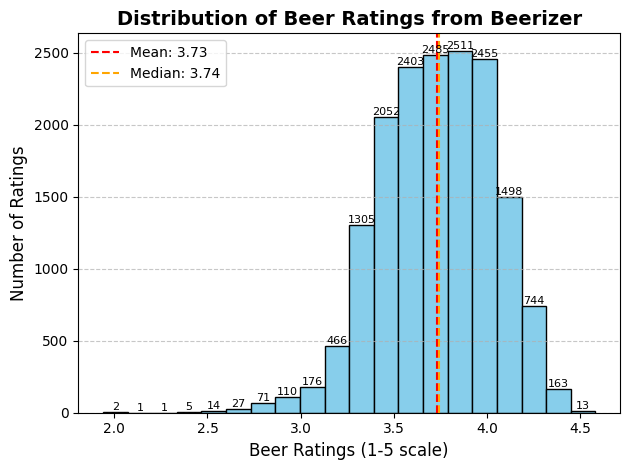

In [217]:
#lets first look at the grade distribution
counts, bins, patches = plt.hist(df_beerizer['Rating'], bins=20, color='skyblue', edgecolor='black')
mean = df_beerizer['Rating'].mean()
median = df_beerizer['Rating'].median()

plt.axvline(mean, color='red', linestyle='--', label=f'Mean: {mean:.2f}')
plt.axvline(median, color='orange', linestyle='--', label=f'Median: {median:.2f}')
plt.legend()

# Annotate Bars
for count, patch in zip(counts, patches):
    plt.text(patch.get_x() + patch.get_width() / 2, count, int(count),
             ha='center', va='bottom', fontsize=8)

plt.xlabel('Beer Ratings (1-5 scale)', fontsize=12)
plt.ylabel('Number of Ratings', fontsize=12)
plt.title('Distribution of Beer Ratings from Beerizer', fontsize=14, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

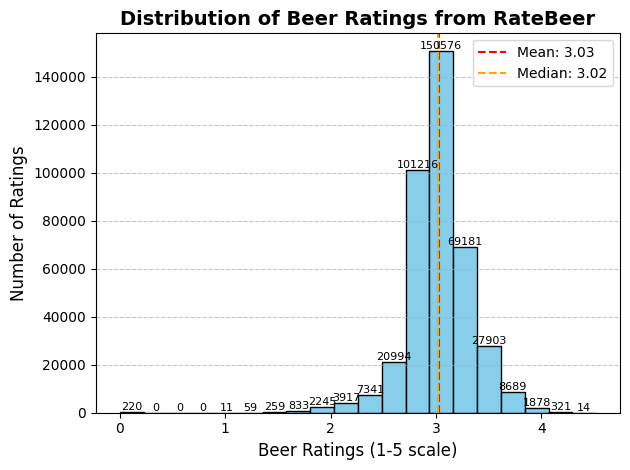

Total number of ratings in Beerizer: 16634


In [218]:
df_RateBeer = pd.read_csv('./RateBeer/beers.csv')
#clean the dataset
#drop rows with missing values
# df_RateBeer = df_RateBeer.dropna()


#lets first look at the grade distribution
counts, bins, patches = plt.hist(df_RateBeer['avg'], bins=20, color='skyblue', edgecolor='black')
mean = df_RateBeer['avg'].mean()
median = df_RateBeer['avg'].median()

plt.axvline(mean, color='red', linestyle='--', label=f'Mean: {mean:.2f}')
plt.axvline(median, color='orange', linestyle='--', label=f'Median: {median:.2f}')
plt.legend()

# Annotate Bars
for count, patch in zip(counts, patches):
    plt.text(patch.get_x() + patch.get_width() / 2, count, int(count),
             ha='center', va='bottom', fontsize=8)

plt.xlabel('Beer Ratings (1-5 scale)', fontsize=12)
plt.ylabel('Number of Ratings', fontsize=12)
plt.title('Distribution of Beer Ratings from RateBeer', fontsize=14, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

#print total number of ratings
print(f"Total number of ratings in Beerizer: {len(df_beerizer)}")

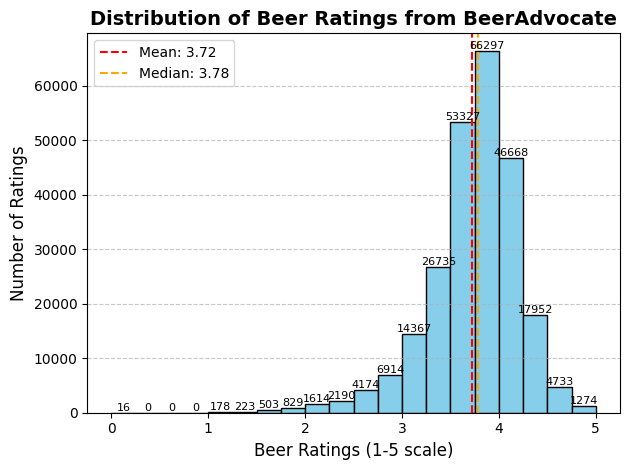

Total number of ratings in BeerAdvocate: 280823


In [219]:
df_BeerAdvocate = pd.read_csv('./BeerAdvocate/beers.csv')
#clean the dataset
#drop rows with missing values
# df_BeerAdvocate = df_BeerAdvocate.dropna()


#lets first look at the grade distribution
counts, bins, patches = plt.hist(df_BeerAdvocate['avg'], bins=20, color='skyblue', edgecolor='black')
mean = df_BeerAdvocate['avg'].mean()
median = df_BeerAdvocate['avg'].median()

plt.axvline(mean, color='red', linestyle='--', label=f'Mean: {mean:.2f}')
plt.axvline(median, color='orange', linestyle='--', label=f'Median: {median:.2f}')
plt.legend()

# Annotate Bars
for count, patch in zip(counts, patches):
    plt.text(patch.get_x() + patch.get_width() / 2, count, int(count),
             ha='center', va='bottom', fontsize=8)

plt.xlabel('Beer Ratings (1-5 scale)', fontsize=12)
plt.ylabel('Number of Ratings', fontsize=12)
plt.title('Distribution of Beer Ratings from BeerAdvocate', fontsize=14, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

#print total number of ratings
print(f"Total number of ratings in BeerAdvocate: {len(df_BeerAdvocate)}")

### Average rating per beer type

In [220]:
mean_grade_per_type = df_beerizer.groupby('Beer_type_general')['Rating'].mean(numeric_only=True)
std_grade_per_type = df_beerizer.groupby('Beer_type_general')['Rating'].std(numeric_only=True)
number_per_type = df_beerizer['Beer_type_general'].value_counts()
mean_grade_per_type = mean_grade_per_type.sort_values(ascending=False)
std_grade_per_type = std_grade_per_type[mean_grade_per_type.index]
number_per_type = number_per_type[mean_grade_per_type.index]
#remove nans
mean_grade_per_type = mean_grade_per_type.dropna()
std_grade_per_type = std_grade_per_type.dropna()
#remove types with less than n ratings
min_number_ratings = 10
mean_grade_per_type = mean_grade_per_type[df_beerizer['Beer_type_general'].value_counts() > min_number_ratings]
std_grade_per_type = std_grade_per_type[df_beerizer['Beer_type_general'].value_counts() > min_number_ratings]
print(f"There is a total of {len(mean_grade_per_type)} beer types with a least {min_number_ratings} ratings")

There is a total of 54 beer types with a least 10 ratings


In [221]:
#save to csv
mean_grade_per_type.to_csv('mean_grade_per_general_type.csv')
df = pd.DataFrame(mean_grade_per_type)
df['std'] = std_grade_per_type
df['count'] = number_per_type
#add quotation marks to the beer type
df.index = df.index.map(lambda x: f'"{x}"')
df.to_csv('mean_grade_per_general_type.csv')

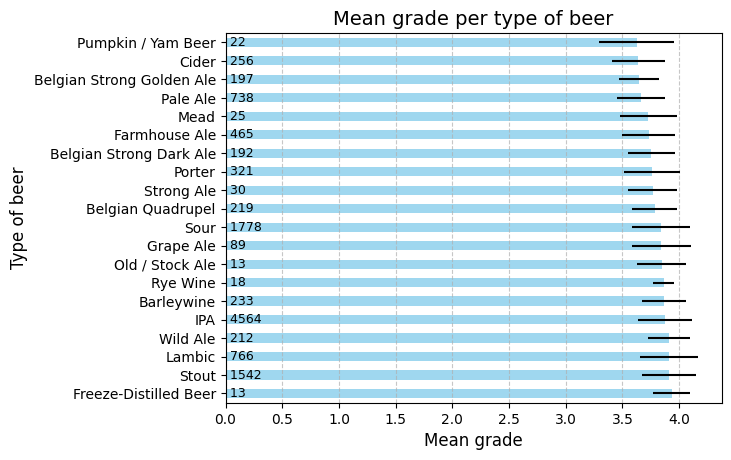

In [222]:
plt.figure()

# Plot the 20 beer types with best grades using a horizontal bar chart
mean_grade_per_type.head(20).plot(kind='barh', xerr=std_grade_per_type.head(20), color='skyblue', alpha=0.8)

# Add numbers of ratings next to the bars
for i, beer_type in enumerate(mean_grade_per_type.head(20).index):
    num_ratings = df_beerizer['Beer_type_general'].value_counts()[beer_type]
    plt.text(0, i, f' {num_ratings}', va='center', ha='left', fontsize=9, color='black')

plt.ylabel('Type of beer', fontsize=12)
plt.xlabel('Mean grade', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.title('Mean grade per type of beer', fontsize=14)
plt.show()

### More precise beer style

Let's now look at more precise beer styles.

In [223]:
mean_grade_per_type = df_beerizer.groupby('Beer_type')['Rating'].mean(numeric_only=True)
std_grade_per_type = df_beerizer.groupby('Beer_type')['Rating'].std(numeric_only=True)
mean_grade_per_type = mean_grade_per_type.sort_values(ascending=False)
std_grade_per_type = std_grade_per_type[mean_grade_per_type.index]
#remove nans
mean_grade_per_type = mean_grade_per_type.dropna()
std_grade_per_type = std_grade_per_type.dropna()
#remove types with less than n ratings
min_number_ratings = 10
mean_grade_per_type = mean_grade_per_type[df_beerizer['Beer_type'].value_counts() > min_number_ratings]
std_grade_per_type = std_grade_per_type[df_beerizer['Beer_type'].value_counts() > min_number_ratings]
print(f"There is a total of {len(mean_grade_per_type)} sub beer types with a mean rating having a least {min_number_ratings} ratings")


There is a total of 179 sub beer types with a mean rating having a least 10 ratings


In [224]:
#save to csv
mean_grade_per_type.to_csv('mean_grade_per_type.csv')
df = pd.DataFrame(mean_grade_per_type)
df['std'] = std_grade_per_type
df['count'] = df_beerizer['Beer_type'].value_counts()
#add quotation marks to the beer type
df.index = df.index.map(lambda x: f'"{x}"')
df.to_csv('mean_grade_per_type.csv')

Let's look into more detail which sub beer style is most appreciated

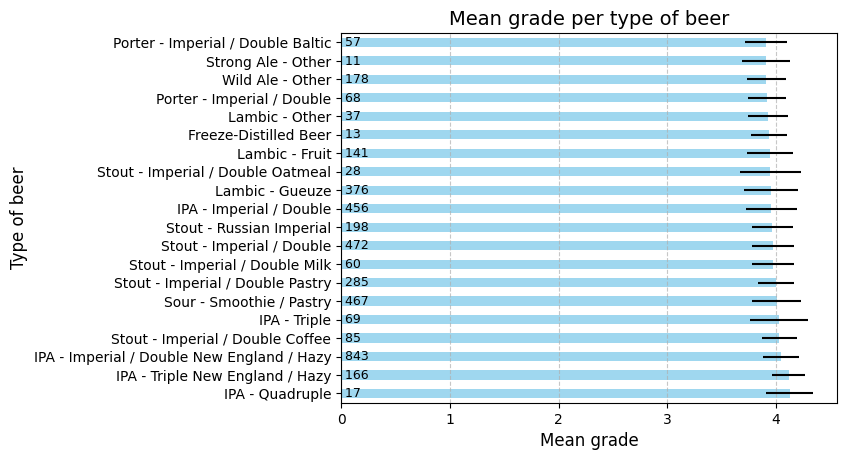

In [225]:
plt.figure()

# Plot the 20 beer types with best grades using a horizontal bar chart
mean_grade_per_type.head(20).plot(kind='barh', xerr=std_grade_per_type.head(20), color='skyblue', alpha=0.8)

# Add numbers of ratings next to the bars
for i, beer_type in enumerate(mean_grade_per_type.head(20).index):
    num_ratings = df_beerizer['Beer_type'].value_counts()[beer_type]
    plt.text(0, i, f' {num_ratings}', va='center', ha='left', fontsize=9, color='black')

plt.ylabel('Type of beer', fontsize=12)
plt.xlabel('Mean grade', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.title('Mean grade per type of beer', fontsize=14)
plt.show()


### Under-represented types, best market entry

Now looking at potential market entry. Satured beer styles might not be the best for newcomers therefore we look at beer styles having less ratings but still with a decent number to have meaningfull data.

There is a total of 48 beer types with a least 5 and less than 20 ratings


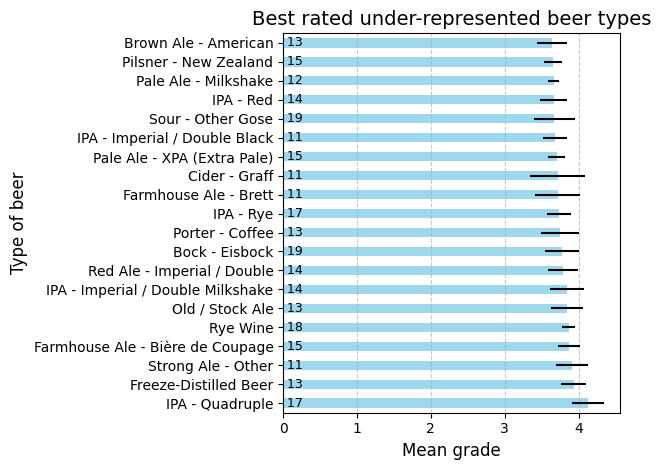

In [226]:
#best rated beers type in a given range of number of ratings
range_ratings = (5, 20)
mean_grade_per_type = mean_grade_per_type[df_beerizer['Beer_type'].value_counts() > range_ratings[0]]
mean_grade_per_type = mean_grade_per_type[df_beerizer['Beer_type'].value_counts() < range_ratings[1]]
std_grade_per_type = std_grade_per_type[df_beerizer['Beer_type'].value_counts() > range_ratings[0]]
std_grade_per_type = std_grade_per_type[df_beerizer['Beer_type'].value_counts() < range_ratings[1]]
plt.figure()

print(f"There is a total of {len(mean_grade_per_type)} beer types with a least {range_ratings[0]} and less than {range_ratings[1]} ratings")

# Plot the 20 beer types with best grades
mean_grade_per_type.head(20).plot(kind='barh', xerr=std_grade_per_type.head(20), color='skyblue', alpha=0.8)

# Add numbers of ratings next to the bars
for i, beer_type in enumerate(mean_grade_per_type.head(20).index):
    num_ratings = df_beerizer['Beer_type'].value_counts()[beer_type]
    plt.text(0, i, f' {num_ratings}', va='center', ha='left', fontsize=9, color='black')

# Adjust labels and title
plt.ylabel('Type of beer', fontsize=12)
plt.xlabel('Mean grade', fontsize=12)
plt.title('Best rated under-represented beer types', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [227]:
#save to csv
mean_grade_per_type.to_csv('mean_grade_per_type_underrepresented.csv')
df = pd.DataFrame(mean_grade_per_type)
df['std'] = std_grade_per_type
df['count'] = df_beerizer['Beer_type'].value_counts()
#add quotation marks to the beer type
df.index = df.index.map(lambda x: f'"{x}"')
df.to_csv('mean_grade_per_type_underrepresented.csv')


### Average price per beer type

In [228]:
mean_price_per_type = df_beerizer.groupby('Beer_type')['Price_per_litter'].mean()
std_price_per_type = df_beerizer.groupby('Beer_type')['Price_per_litter'].std()
#remove nans
mean_price_per_type = mean_price_per_type.dropna()
std_price_per_type = std_price_per_type.dropna()
#remove types with less than 10 prices
min_number_beers = 10
mean_price_per_type = mean_price_per_type[df_beerizer['Beer_type'].value_counts() > min_number_beers]
std_price_per_type = std_price_per_type[df_beerizer['Beer_type'].value_counts() > min_number_beers]


In [229]:
#save to csv
mean_price_per_type.to_csv('mean_price_per_type.csv')
df = pd.DataFrame(mean_price_per_type)
df['std'] = std_price_per_type
df['count'] = df_beerizer['Beer_type'].value_counts()
df.index = df.index.map(lambda x: f'"{x}"')
df.to_csv('mean_price_per_type.csv')


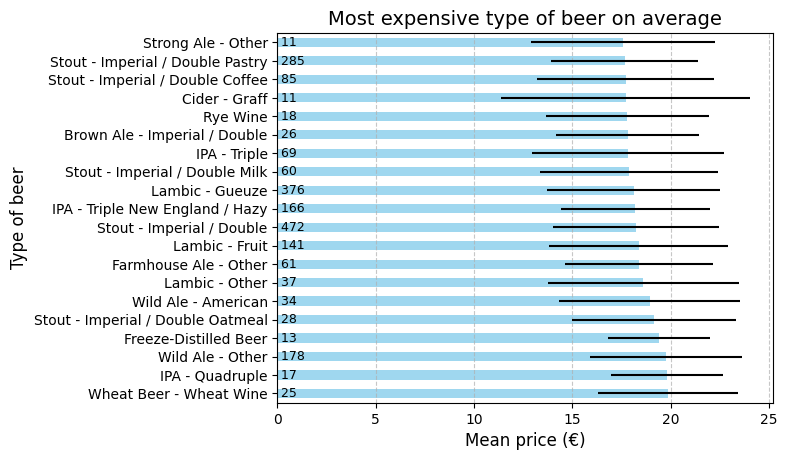

In [230]:
plt.figure()

mean_price_per_type = mean_price_per_type.sort_values(ascending=False)
std_price_per_type = std_price_per_type[mean_price_per_type.index]

# Plot the 20 more expensive beer types
mean_price_per_type.head(20).plot(kind='barh', xerr=std_price_per_type.head(20), color='skyblue', alpha=0.8)


# Add numbers of ratings next to the bars
for i, beer_type in enumerate(mean_price_per_type.head(20).index):
    num_ratings = df_beerizer['Beer_type'].value_counts()[beer_type]
    plt.text(0, i, f' {num_ratings}', va='center', ha='left', fontsize=9, color='black')

plt.ylabel('Type of beer', fontsize=12)
plt.xlabel('Mean price (€)', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.title('Most expensive type of beer on average', fontsize=14)
plt.show()


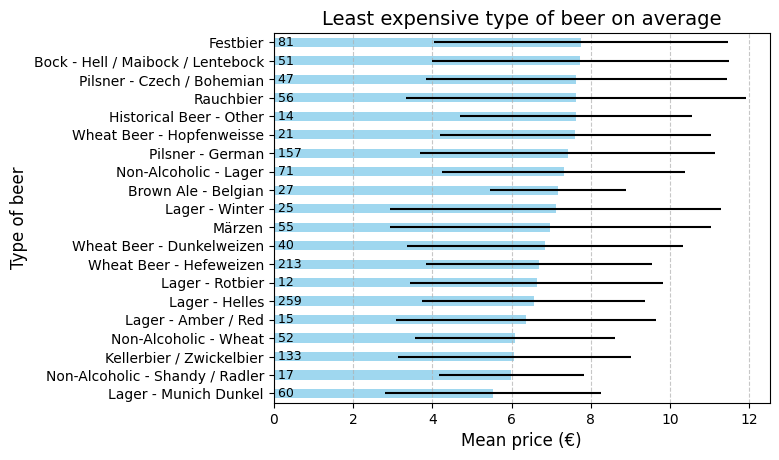

In [231]:
plt.figure()

mean_price_per_type = mean_price_per_type.sort_values(ascending=True)
std_price_per_type = std_price_per_type[mean_price_per_type.index]

# Plot the 20 more expensive beer types
mean_price_per_type.head(20).plot(kind='barh', xerr=std_price_per_type.head(20), color='skyblue', alpha=0.8)


# Add numbers of ratings next to the bars
for i, beer_type in enumerate(mean_price_per_type.head(20).index):
    num_ratings = df_beerizer['Beer_type'].value_counts()[beer_type]
    plt.text(0, i, f' {num_ratings}', va='center', ha='left', fontsize=9, color='black')

plt.ylabel('Type of beer', fontsize=12)
plt.xlabel('Mean price (€)', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.title('Least expensive type of beer on average', fontsize=14)
plt.show()


### Average price and rating depending on the origin

In [232]:
origins = df_beerizer['Origin'].unique()
print(f"There are {len(origins)} different origins in the dataset")
df_origins = pd.DataFrame(index=origins, columns=['Mean_grade', 'std_grade', 'Number_beers', 'Mean_price_euro_per_litter', 'std_price'])
df_origins.index.name = 'Origin'

df_origins['Mean_grade'] = df_beerizer.groupby('Origin')['Rating'].mean()
df_origins['std_grade'] = df_beerizer.groupby('Origin')['Rating'].std()
df_origins['std_grade'] = df_origins['std_grade'].fillna(0)
df_origins['Number_beers'] = df_beerizer['Origin'].value_counts()
df_origins['Mean_price_euro_per_litter'] = df_beerizer.groupby('Origin')['Price_per_litter'].mean()
df_origins['std_price'] = df_beerizer.groupby('Origin')['Price_per_litter'].std()
df_origins['std_price'] = df_origins['std_price'].fillna(0)
df_origins.index = df_origins.index.map(lambda x: f'{x}')
#save to csv
df_origins.reset_index(inplace=True)
df_origins.to_csv('origin_stats.csv')


There are 58 different origins in the dataset


In [233]:

fig = px.choropleth(
    df_origins,
    locations="Origin",  
    locationmode="country names",  
    color="Mean_price_euro_per_litter",  
    title="Beer Statistics by Country",
    color_continuous_scale="Viridis", 
)


# Customize layout
fig.update_layout(
    title_font_size=18,
    geo=dict(
        showframe=False,
        showcoastlines=True,
        projection_type="natural earth"
    )
)

fig.show()

#### Price normalized depending on the average income

In [234]:
df_median_income = pd.read_csv('median-income-per-year-after-tax.csv')
df_median_income = df_median_income.dropna()
#rename columns
df_median_income = df_median_income.rename(columns={'Median income (after tax)':'Income'})
#keep only lines with Year > 2015
df_median_income = df_median_income[df_median_income['Year'] > 2015]
#keep the latest year for each country
df_median_income = df_median_income.sort_values('Year').drop_duplicates('Country', keep='last')
print(len(df_median_income))

print(df_origins.head())

df_origins = df_origins.merge(df_median_income, left_on='Origin', right_on='Country', how='left')
df_origins['Price_norm_income_score'] = df_origins['Mean_price_euro_per_litter'] / df_origins['Income'] 
#normalize between 0 to 100
df_origins['Price_norm_income_score'] = (df_origins['Price_norm_income_score'] - df_origins['Price_norm_income_score'].min()) / (df_origins['Price_norm_income_score'].max() - df_origins['Price_norm_income_score'].min()) * 100

df_origins.to_csv('origin_stats.csv')


42
          Origin  Mean_grade  std_grade  Number_beers  \
0    Netherlands    3.615396   0.276258          2649   
1  United States    3.956712   0.237482          1866   
2          Spain    3.871045   0.214363           539   
3         Poland    3.721273   0.252546           858   
4        England    3.792504   0.254983          1302   

   Mean_price_euro_per_litter  std_price  
0                   12.774337   4.186616  
1                   17.370932   5.118111  
2                   15.751948   3.976101  
3                   10.244545   4.768301  
4                   14.386966   3.964234  


In [254]:
#plot the price normalized by income on a map
fig = px.choropleth(
    df_origins,
    locations="Origin",  
    locationmode="country names",  
    color="Price_norm_income_score",  
    title="Beer Price adjsuter by mean Income",
    color_continuous_scale="Viridis", 
)


# Customize layout
fig.update_layout(
    title_font_size=18,
    geo=dict(
        showframe=False,
        showcoastlines=True
    )
)


### Price distribution depending on origin and beer type

In [235]:
df = df_beerizer.copy()

# Dropdown widgets for filtering
beer_type_dropdown = widgets.Dropdown(
    options=['All'] + list(df['Beer_type'].unique()),
    value='All',
    description='Beer Type:',
)
origin_dropdown = widgets.Dropdown(
    options=['All'] + list(df['Origin'].unique()),
    value='All',
    description='Origin:',
)

# Function to update the plot
def update_plot(beer_type, origin):
    filtered_df = df.copy()
    if beer_type != 'All':
        filtered_df = filtered_df[filtered_df['Beer_type'] == beer_type]
    if origin != 'All':
        filtered_df = filtered_df[filtered_df['Origin'] == origin]

    # Calculate price range
    if not filtered_df.empty:
        price_min = filtered_df['Price_per_litter'].min()
        price_max = filtered_df['Price_per_litter'].max()
        print(f"Price range: {price_min:.2f} - {price_max:.2f}")
    else:
        print("No data for the selected filters.")

    # Create an interactive plot with Plotly
    fig = px.box(
        filtered_df,
        x='Beer_type',
        y='Price_per_litter',
        color='Origin',
        title="Price Distribution by Beer Type and Origin",
        labels={'Price_per_litter': 'Price (€/l)', 'Beer_type': 'Beer Type'},
        
    )
    fig.show()

widgets.interactive(update_plot, beer_type=beer_type_dropdown, origin=origin_dropdown)
display(beer_type_dropdown, origin_dropdown)

Dropdown(description='Beer Type:', options=('All', 'Barleywine - Other', 'Stout - Milk / Sweet', 'IPA - New En…

Dropdown(description='Origin:', options=('All', 'Netherlands', 'United States', 'Spain', 'Poland', 'England', …

In [236]:
#save to csv
df = df_beerizer.copy()
df.drop(columns=['Beer_name', 'Brewery', 'Countenance', 'Volume_ml', ], inplace=True)
df['Origin'] = df['Origin'].map(lambda x: f'"{x}"')
df['Beer_type'] = df['Beer_type'].map(lambda x: f'"{x}"')
df['Beer_type_general'] = df['Beer_type_general'].map(lambda x: f'"{x}"')
df.to_csv('interact_beerizer.csv', index=False)

### Cross check grades from other dataset

RateBeer and Untappd

In [237]:
from difflib import SequenceMatcher

def similar(a, b):
    """
    Calculate the similarity ratio between two strings.
    """
    return SequenceMatcher(None, a, b).ratio()

def match_and_combine_datasets(df1, df2):
    """
    Matches and combines two datasets based on beer names and brewery similarity.

    Parameters:
        df1 (pd.DataFrame): First dataframe with columns "Beer_name" and "Brewery".
        df2 (pd.DataFrame): Second dataframe with columns "beer_name" and "brewery_name".

    Returns:
        pd.DataFrame: A new dataframe containing matched beers with combined information.
    """
    # Rename columns to a common name for merging
    df1 = df1.rename(columns={"Beer_name": "common_beer_name", "Brewery": "common_brewery"})
    df2 = df2.rename(columns={"beer_name": "common_beer_name", "brewery_name": "common_brewery"})

    # Perform an initial match on beer names
    combined_df = pd.merge(df1, df2, on="common_beer_name", how="inner")
    

    # Filter rows where the brewery names are at least 50% similar
    combined_df = combined_df[combined_df.apply(
        lambda row: similar(row["common_brewery_x"], row["common_brewery_y"]) >= 0.5, axis=1
    )]

    # Optional: Rename the common columns back to preferred names
    combined_df = combined_df.rename(columns={"common_beer_name": "Beer_name", "common_brewery_x": "Brewery_df1", "common_brewery_y": "Brewery_df2"})

    return combined_df

# Example usage:
df1 = pd.read_csv("cleaned_beerizer.csv")
df2 = pd.read_csv("./RateBeer/beers.csv")
combined_dataset = match_and_combine_datasets(df1, df2)
combined_dataset.to_csv("matched_dataset.csv", index=False)
print(f"initial dataset length: {len(df1)} and matched dataset length: {len(combined_dataset)}")

initial dataset length: 16634 and matched dataset length: 251


Look at the difference between the grading

In [238]:
#calculate the difference in grades between the two datasets
combined_dataset['Rating_diff'] = combined_dataset['Rating'] - combined_dataset['avg']
combined_dataset['Rating_diff'] = combined_dataset['Rating_diff'].fillna(0)
combined_dataset['Rating_diff'] = combined_dataset['Rating_diff'].abs()
print(f"Mean difference in grades: {combined_dataset['Rating_diff'].mean():.2f}")

Mean difference in grades: 0.32


BeerAdvocate and Untappd

In [239]:
from difflib import SequenceMatcher

def similar(a, b):
    """
    Calculate the similarity ratio between two strings.
    """
    return SequenceMatcher(None, a, b).ratio()

def match_and_combine_datasets(df1, df2):
    """
    Matches and combines two datasets based on beer names and brewery similarity.

    Parameters:
        df1 (pd.DataFrame): First dataframe with columns "Beer_name" and "Brewery".
        df2 (pd.DataFrame): Second dataframe with columns "beer_name" and "brewery_name".

    Returns:
        pd.DataFrame: A new dataframe containing matched beers with combined information.
    """
    # Rename columns to a common name for merging
    df1 = df1.rename(columns={"Beer_name": "common_beer_name", "Brewery": "common_brewery"})
    df2 = df2.rename(columns={"beer_name": "common_beer_name", "brewery_name": "common_brewery"})

    # Perform an initial match on beer names
    combined_df = pd.merge(df1, df2, on="common_beer_name", how="inner")
    

    # Filter rows where the brewery names are at least 50% similar
    combined_df = combined_df[combined_df.apply(
        lambda row: similar(row["common_brewery_x"], row["common_brewery_y"]) >= 0.9, axis=1
    )]

    # Optional: Rename the common columns back to preferred names
    combined_df = combined_df.rename(columns={"common_beer_name": "Beer_name", "common_brewery_x": "Brewery_df1", "common_brewery_y": "Brewery_df2"})

    return combined_df

# Example usage:
df1 = pd.read_csv("cleaned_beerizer.csv")
df2 = pd.read_csv("./BeerAdvocate/beers.csv")
combined_dataset = match_and_combine_datasets(df1, df2)
combined_dataset.to_csv("matched_dataset_BA.csv", index=False)
print(f"initial dataset length: {len(df1)} and matched dataset length: {len(combined_dataset)}")

initial dataset length: 16634 and matched dataset length: 431


In [240]:
combined_dataset['Rating_diff'] = combined_dataset['Rating'] - combined_dataset['avg']
combined_dataset['Rating_diff'] = combined_dataset['Rating_diff'].fillna(0)
combined_dataset['Rating_diff'] = combined_dataset['Rating_diff'].abs()
print(f"Mean difference in grades: {combined_dataset['Rating_diff'].mean():.2f}")

Mean difference in grades: 0.27


Redo the same calculations ?

## Newcomers

In [241]:
from difflib import SequenceMatcher

def similar(a, b):
    """
    Calculate the similarity ratio between two strings.
    """
    return SequenceMatcher(None, a, b).ratio()

def match_and_combine_datasets(df1, df2):
    """
    Matches and combines two datasets based on beer names and brewery similarity.

    Parameters:
        df1 (pd.DataFrame): First dataframe with columns "Beer_name" and "Brewery".
        df2 (pd.DataFrame): Second dataframe with columns "beer_name" and "brewery_name".

    Returns:
        pd.DataFrame: A new dataframe containing matched beers with combined information.
    """
    # Rename columns to a common name for merging
    df1 = df1.rename(columns={"Beer_name": "common_beer_name"})
    df2 = df2.rename(columns={"ba_beer_name": "common_beer_name"})

    # Perform an initial match on beer names
    combined_df = pd.merge(df1, df2, on="common_beer_name", how="inner")
    


    # Optional: Rename the common columns back to preferred names
    combined_df = combined_df.rename(columns={"common_beer_name": "Beer_name"})

    return combined_df

# Example usage:
df1 = pd.read_csv("cleaned_beerizer.csv")
df2 = pd.read_csv("top_reviews.csv")
combined_dataset = match_and_combine_datasets(df1, df2)
combined_dataset.to_csv("matched_dataset_BA.csv", index=False)
print(f"initial dataset length: {len(df1)} and matched dataset length: {len(combined_dataset)}")

initial dataset length: 16634 and matched dataset length: 0


No matches :()

### Match Beerizer with matched dataset from BeerAdvocate and RateBeer

In [242]:
df_matched_beers_BA_RB = pd.read_csv("./matched_beer_data/beers.csv", header=[0,1])
df_matched_beers_BA_RB.columns = df_matched_beers_BA_RB.columns.map('_'.join)
# print(df_matched_beers_BA_RB.head())

In [243]:
# from rapidfuzz import process, fuzz  # Faster alternative to fuzzywuzzy
# from tqdm import tqdm

# # Optimized function to find and merge matches with a second check for brewery names
# def merge_matched_rows_with_brewery_check(df1, df2, column1, column2, brewery_col1, brewery_col2, threshold=80, brewery_threshold=80):
#     """
#     Merges rows from df1 and df2 based on the similarity of beer names, with an additional check for brewery names.
#     """
#     merged_rows = []  # Store the merged rows
#     df2_names = df2[column2].tolist()  # Convert df2's beer names to a list for rapid comparisons

#     for _, row1 in tqdm(df1.iterrows(), total=len(df1), desc="Matching and merging rows"):
#         name1 = row1[column1]
#         brewery1 = row1[brewery_col1]
#         result = process.extractOne(
#             name1, df2_names, scorer=fuzz.token_sort_ratio, score_cutoff=threshold
#         )
#         if result:  # If a beer name match is found
#             best_match = result[0]  # Best-matched beer name from df2
#             row2 = df2[df2[column2] == best_match].iloc[0]  # Get the corresponding row from df2
#             brewery2 = row2[brewery_col2]

#             # Perform a second check on the brewery names
#             brewery_score = fuzz.token_sort_ratio(brewery1, brewery2)
#             if brewery_score >= brewery_threshold:  # Only keep the match if breweries are similar enough
#                 merged_row = pd.concat([row1, row2])  # Merge row1 and row2
#                 merged_rows.append(merged_row)


#     return pd.DataFrame(merged_rows)

# # Example Usage
# df1 = pd.read_csv("cleaned_beerizer.csv")
# df2 = df_matched_beers_BA_RB

# # Perform matching and merging
# final_df = merge_matched_rows_with_brewery_check(
#     df1, df2, 
#     column1='Beer_name', column2='ba_beer_name', 
#     brewery_col1='Brewery', brewery_col2='ba_brewery_name', 
#     threshold=80, brewery_threshold=80
# )

# # Save or inspect the result
# print(final_df.head())


In [244]:
# final_df.to_csv("matched_dataset_BA_RB_UT.csv", index=False)

In [ ]:
import pandas as pd
import csv

def export_csv(dataset: pd.DataFrame, filename: str) -> None:
    copy_data = dataset.copy()
    copy_data.replace('', np.nan, inplace=True)
    copy_data.to_csv(f"{filename}.csv", index=False, quotechar='"', quoting=csv.QUOTE_NONNUMERIC, na_rep='NaN')


if __name__=="__main__":
    df = pd.read_csv('country_analysis3.csv')
    export_csv(df, 'country_analysis3_test')